### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import re

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(text).lower()
text

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.\n\n  ii\n\n  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were

In [4]:
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.
#text = "".join(text).lower()
#text
# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
chars = tuple(set(text))
token_to_idx = dict() 
for index, value in enumerate(chars):
    token_to_idx[value] = index
print('token_to_idx:', token_to_idx)
    
# dict <char>:<index>
# Your great code here
    
idx_to_token = dict() 
for index, value in enumerate(chars):
    idx_to_token[index] = value
print('idx_to_token', idx_to_token)

token_to_idx: {'v': 0, 'm': 1, 'b': 2, ')': 3, 't': 4, 'g': 5, '-': 6, '\n': 7, 'a': 8, '.': 9, ',': 10, ';': 11, 'x': 12, 'l': 13, 'z': 14, 'p': 15, '?': 16, 'f': 17, 'o': 18, 'y': 19, ':': 20, 'n': 21, 'e': 22, 's': 23, 'q': 24, '(': 25, '!': 26, 'd': 27, "'": 28, 'k': 29, 'u': 30, 'h': 31, 'r': 32, 'w': 33, 'c': 34, ' ': 35, 'i': 36, 'j': 37}
idx_to_token {0: 'v', 1: 'm', 2: 'b', 3: ')', 4: 't', 5: 'g', 6: '-', 7: '\n', 8: 'a', 9: '.', 10: ',', 11: ';', 12: 'x', 13: 'l', 14: 'z', 15: 'p', 16: '?', 17: 'f', 18: 'o', 19: 'y', 20: ':', 21: 'n', 22: 'e', 23: 's', 24: 'q', 25: '(', 26: '!', 27: 'd', 28: "'", 29: 'k', 30: 'u', 31: 'h', 32: 'r', 33: 'w', 34: 'c', 35: ' ', 36: 'i', 37: 'j'}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

One-hot encoding is the most common, most basic way to turn a token into a vector. One-hot encoding can be done at the character level too.

In [8]:
import numpy as np
one_hot_encoded = []
for char in text:
    one_hot_encoded.append(token_to_idx[char])
one_hot_encoded = np.array(one_hot_encoded)
one_hot_encoded

array([35, 35, 17, ..., 22,  9,  7])

In [9]:
texts = np.asarray(text)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
import torch
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self, chars):
        super(RNN, self).__init__()
        self.hidden_size = 256
        self.lr = 1e-3
        self.input_size = 2
        self.chars = chars
        self.rnn = nn.RNN(len(chars), self.hidden_size, self.input_size, dropout=0.5, batch_first=True)
        #self.embedding = nn.Embedding(self.input_size, 256)
        #self.gru = nn.GRU(hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size ,len(chars))

    def forward(self, input, hidden):
        
        out, hidden = self.rnn(input, hidden)
        #out = self.embedding(out)
        out = out.contiguous().view(-1, 256) # contiguous to reshape the output
        out = self.linear(out)
        return out, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, 256)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [11]:
def train(model, data, typeM, epochs=100, batch_size=128, seqLength=30):

    model.train()
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    criterion = nn.CrossEntropyLoss()

    loss_total = list()
    n_labels = len(model.chars)
    for e in range(1, epochs + 1):
        h = model.initHidden(batch_size)
        for x, y in get_batches(data, batch_size, seqLength):
            batch_total = batch_size*seqLength
            # Torch tensors
            tt = np.zeros((x.size, n_labels), dtype=np.float32)
            tt[np.arange(tt.shape[0]), x.flatten()] = 1.
            x = tt.reshape((*x.shape, n_labels))
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            if typeM == 'LSTM':
                h = tuple([one.data for one in h])
            else:
                h = h.data
            model.zero_grad()
            out, h = model(inputs, h)
            loss = criterion(out, targets.view(batch_total).long())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 10)
            opt.step()
        loss_total.append(loss.item())
        print("Epoch: {}/{}...".format(e, epochs),
            "Loss:{:.3f}...".format(loss.item()))
    return loss_total

In [12]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [13]:
def get_batches(data, batch_size, seqLength):
    batch_total = batch_size * seqLength
    n_batches = len(data)//batch_total

    data = data[:n_batches * batch_total]
    data = data.reshape((batch_size, -1))
    for n in range(0, data.shape[1], seqLength):
        x = data[:, n:n + seqLength]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], data[:, n + seqLength]
        except IndexError:
            y[:, :-1],y[:, -1] = x[:, 1:], data[:, 0]
        yield x, y

In [14]:
model = RNN(tokens)
model

RNN(
  (rnn): RNN(38, 256, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [15]:
loss_total = train(model, one_hot_encoded, 'RNN')

Epoch: 1/100... Loss:2.923...
Epoch: 2/100... Loss:2.632...
Epoch: 3/100... Loss:2.366...
Epoch: 4/100... Loss:2.245...
Epoch: 5/100... Loss:2.169...
Epoch: 6/100... Loss:2.116...
Epoch: 7/100... Loss:2.067...
Epoch: 8/100... Loss:2.039...
Epoch: 9/100... Loss:2.012...
Epoch: 10/100... Loss:1.981...
Epoch: 11/100... Loss:1.944...
Epoch: 12/100... Loss:1.920...
Epoch: 13/100... Loss:1.895...
Epoch: 14/100... Loss:1.889...
Epoch: 15/100... Loss:1.856...
Epoch: 16/100... Loss:1.847...
Epoch: 17/100... Loss:1.823...
Epoch: 18/100... Loss:1.808...
Epoch: 19/100... Loss:1.790...
Epoch: 20/100... Loss:1.773...
Epoch: 21/100... Loss:1.762...
Epoch: 22/100... Loss:1.748...
Epoch: 23/100... Loss:1.734...
Epoch: 24/100... Loss:1.720...
Epoch: 25/100... Loss:1.708...
Epoch: 26/100... Loss:1.700...
Epoch: 27/100... Loss:1.682...
Epoch: 28/100... Loss:1.675...
Epoch: 29/100... Loss:1.668...
Epoch: 30/100... Loss:1.654...
Epoch: 31/100... Loss:1.643...
Epoch: 32/100... Loss:1.637...
Epoch: 33/100... 

In [16]:
import matplotlib.pyplot as plt
def plot_loss(loss_total):
    plt.figure(figsize=(10, 5))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(loss_total)
    plt.legend()
    plt.title("Loss plot")
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


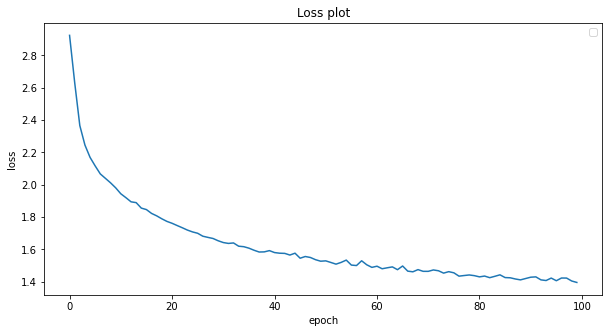

In [17]:
plot_loss(loss_total)

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [18]:
class LSTM(nn.Module):
    def __init__(self, chars):
        super(LSTM, self).__init__()
        self.hidden_size = 256
        self.lr = 1e-3
        self.input_size = 2
        self.chars = chars
        self.lstm=nn.LSTM(len(chars), 256, 2, dropout=0.5, batch_first=True)
        #self.embedding = nn.Embedding(self.input_size, 256)
        #self.gru = nn.GRU(hidden_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size ,len(chars))

    def forward(self, input, hidden):
        
        out, hidden = self.lstm(input, hidden)
        #out = self.embedding(out)
        out = out.contiguous().view(-1, 256) # contiguous to reshape the output
        out = self.linear(out)
        return out, hidden

    def initHidden(self, batch_size):
        return (torch.zeros(2, batch_size, 256),torch.zeros(2, batch_size, 256))

In [19]:
model_LSTM = LSTM(tokens)
model_LSTM

LSTM(
  (lstm): LSTM(38, 256, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [20]:
loss_total_LSTM = train(model_LSTM, one_hot_encoded, 'LSTM')

Epoch: 1/100... Loss:2.966...
Epoch: 2/100... Loss:2.954...
Epoch: 3/100... Loss:2.941...
Epoch: 4/100... Loss:2.846...
Epoch: 5/100... Loss:2.661...
Epoch: 6/100... Loss:2.530...
Epoch: 7/100... Loss:2.366...
Epoch: 8/100... Loss:2.292...
Epoch: 9/100... Loss:2.229...
Epoch: 10/100... Loss:2.178...
Epoch: 11/100... Loss:2.125...
Epoch: 12/100... Loss:2.083...
Epoch: 13/100... Loss:2.051...
Epoch: 14/100... Loss:2.010...
Epoch: 15/100... Loss:1.974...
Epoch: 16/100... Loss:1.945...
Epoch: 17/100... Loss:1.909...
Epoch: 18/100... Loss:1.912...
Epoch: 19/100... Loss:1.873...
Epoch: 20/100... Loss:1.870...
Epoch: 21/100... Loss:1.851...
Epoch: 22/100... Loss:1.824...
Epoch: 23/100... Loss:1.794...
Epoch: 24/100... Loss:1.775...
Epoch: 25/100... Loss:1.764...
Epoch: 26/100... Loss:1.742...
Epoch: 27/100... Loss:1.725...
Epoch: 28/100... Loss:1.719...
Epoch: 29/100... Loss:1.696...
Epoch: 30/100... Loss:1.691...
Epoch: 31/100... Loss:1.667...
Epoch: 32/100... Loss:1.663...
Epoch: 33/100... 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


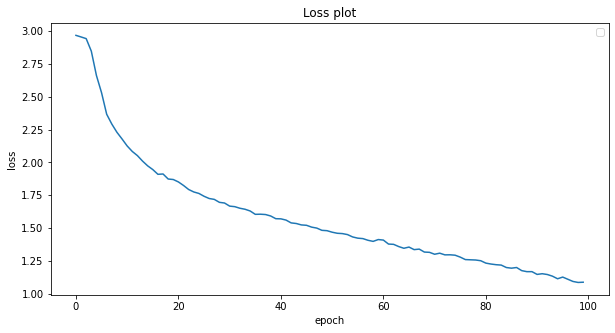

In [21]:
plot_loss(loss_total_LSTM)

#### The final loss became better with LSTM and it took more time

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [22]:
len(model.chars)

38

In [23]:
import torch.nn.functional as F
def get_char(char_rnn, char, hidden_state, typeM, temperature, tk):
    n_labels = len(char_rnn.chars)
    x = np.array([[token_to_idx[char]]])
    #print('token_to_idx[char]',token_to_idx[char])
    
    tt = np.zeros((x.size, n_labels), dtype=np.float32)
    tt[np.arange(tt.shape[0]), x.flatten()] = 1.
    x = tt.reshape((*x.shape, n_labels))
    inputs = torch.from_numpy(x)
    if typeM == 'LSTM':
        hid_state = tuple([one.data for one in hidden_state])
    else:
        hid_state = hidden_state.data
    out, hid_state = char_rnn(inputs, hid_state)
    p_next = F.softmax(out / temperature, dim=-1).data
    
    p_next, num_tokens = p_next.topk(tk)    
    num_tokens = num_tokens.numpy().squeeze()   
    
    p_next = p_next.numpy().squeeze()
   
    next_ix = np.random.choice(num_tokens, p=p_next/p_next.sum())
    #print('next_ix', next_ix)
    return idx_to_token[next_ix], hid_state


In [32]:
def generate_sample(char_rnn, size, seed_phrase, typeM, temperature, tk=15):
    '''
    The function generates text given a phrase or word.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_rnn.cpu()
    char_rnn.eval()
    
    hidden_state = char_rnn.initHidden(1)
    #print(hidden_state)
    chars = [c for c in seed_phrase]
    
    for c in seed_phrase:
        char, hidden_state = get_char(char_rnn, c, hidden_state, typeM, temperature, tk)
    chars.append(char)

    for i in range(size):
        char, hidden_state = get_char(char_rnn, chars[-1], hidden_state, typeM, temperature, tk)
        chars.append(char)
    
    return ''.join(chars)

In [33]:
print(generate_sample(model, 500, seed_phrase='share', typeM = 'RNN', temperature=0.2))

share is not to thee.

  xcvii

  the carth the summer than the world doth lies,
  and therefore to thee in the sun one hours and heart
  the best i am a for the summer to thee in thee.

  cxxxii

  the carring stay the world to thee in thee in thee,
  which in me that is to thee in thee,
    the world will not so farther than the summer's did doth stays,
  the could not so farther than the summer to make to thee.

  xcviii

  that i am for my love thee in the sun one,
    then thou art the world me t


In [34]:
print(generate_sample(model_LSTM, 500, seed_phrase='share', typeM = 'LSTM', temperature=0.2))

share i am not so great find.
    the world will be thy meant and happy both space,
  which have i seen to thee doth prove,
  which i think me well be still my dead.

  xcii

  love you are not to gracious as i found,
  with the tome of the fair which in thee shall be all,
  the world will be the world of some woe;
  but that which i be gondent must be thee,
  when i have seen the fair where you do i not so;
    to speak a scope with thee, and therefore me not,
  to make me wit see not the fair world 


In [36]:
temps = [0.1, 0.2, 0.5, 1.0, 2.0]
for i in temps:
    print('temp=', i)
    print(generate_sample(model_LSTM, 500, seed_phrase='share', typeM = 'LSTM', temperature=0.2))
    print('end of poem \n')



temp= 0.1
share not thy sight,
  and for the world words of this proud of says are dead;
  and so my part i am not so great doth lie,
  the eyes comments of thy praise to write!
  when i am sometime and make the world away.
    the beauty of the reasons of thy state,
  and see the blood world of your praise.

  lxxxxii

  so all my heart that thoughts of more,
  and to the beauty of the true so the leasure,
  and thou art all the power of all thy dear.

  lxxxii

  those world will be the world would be bereft,
end of poem 

temp= 0.2
share not the store to be reseave,
  and therefore to the world of such a told,
  and see the fair where all the world must death,
  that heaven's sorrow and thine own love's part,
  that thou art to the world with the store would can mend,
  and thou are nothing strange shadows doth the store,
  when i have seen the world of sours words do stone,
  and see the breather of show with thee down bear,
  the ornent of any eye, but when they despise,
  which h

#### as expected higher temperature produces more chaotic outputs, smaller temperature converges to the single most likely output

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [65]:
PATH = 'MyModel.net'
torch.save(model, PATH)

In [66]:
model_new = torch.load(PATH)
model_new.eval()

RNN(
  (rnn): RNN(38, 256, num_layers=2, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=256, out_features=38, bias=True)
)

In [70]:
print(generate_sample(model_new, 200, seed_phrase='cook', typeM = 'RNN', temperature=0.2))

cook doth steel
  that thou art as the summer to thee,
  when i am for the world will be thee in thee,
  when i have stays how see the summer's did doth state,
  and therefore that thou be fair from thee,



### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)